## libraries

In [2]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import keras
import tensorflow as tf
import keras.backend as K
from collections import Counter
from tensorflow.python.client import device_lib
from keras.optimizers import Adam, Adamax, SGD
import imutils
import tensorflow_addons as tfa
from keras.models import load_model

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)
tf.keras.backend.clear_session()
TF_ENABLE_ONEDNN_OPTS=0
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(tf.device('/gpu:0'))

tf.device('/gpu:0')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
base_path="/home/neel/Acoustic/Acoustics/dataset"
audio_path=os.path.sep.join([base_path,"datachunks"])
annots_path=os.path.sep.join([base_path,"train.csv"])

base_output="/home/neel/Acoustic/Acoustics/output3.0"
test_file=os.path.sep.join([base_output,"test.txt"])

## Generate Spectrograms and labels

In [6]:
print("[INFO] loading dataset...")
rows = open(annots_path).read().strip().split("\n")
spectrogram=np.empty(((len(rows)),257,273,2), dtype="float32")
bounding_box_cords=[]
window_size=int(512)
wd = signal.windows.hamming(window_size)
slide_size = int(4)
overlap = window_size - slide_size
filenames=[]
cnt=0
for row in rows:
    # print(cnt)
    row = row.split(",")
    (filename1,filename2,X1, Y1, X2, Y2) = row
    channel1_Path = os.path.sep.join([audio_path, filename1])
    channel2_path = os.path.sep.join([audio_path, filename2])
    
    channel1,sample_rate=librosa.load(channel1_Path,sr=None)
    channel2,sample_rate=librosa.load(channel2_path,sr=None)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')

    # print(image1.shape)
    data=np.stack((spectrum1,spectrum2),axis=-1)
    spectrogram[cnt]=data
    del data,frequency,time
    cnt+=1
    bounding_box_cords.append((X1, Y1, X2, Y2))
    filenames.append([filename1,filename2])
    # filenames.append(filename1)
print("Done.")

[INFO] loading dataset...
Done.


## Normalize spectrogram

In [7]:
print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))
for i in range(8831):
    min=spectrogram[i].min()
    max=spectrogram[i].max()
    spectrogram[i]= (spectrogram[i]-min)/(max-min)


print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))

Min: 0.000, Max: 0.017
Min: 0.000, Max: 1.000


In [8]:
del channel1,channel2,rows,spectrum1,spectrum2


In [9]:
targets = np.array(bounding_box_cords, dtype="float32")
print(targets.shape)
print(spectrogram.shape)

(8840, 4)
(8840, 257, 273, 2)


## Train - Validation split

In [10]:
split = train_test_split(spectrogram, targets, filenames, test_size=0.10,random_state=42)
del spectrogram, targets, filenames
(trainData, testData) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
del split

print("[INFO] saving testing filenames...")
f = open(test_file, "w")
for i in testFilenames:
    f.write(i[0]+","+i[1])
    f.write("\n")
# f.write("\n".join(testFilenames))
f.close()

print("Training examples: ",trainData.shape)
print("Testing examples: ",testData.shape)

[INFO] saving testing filenames...
Training examples:  (7956, 257, 273, 2)
Testing examples:  (884, 257, 273, 2)


## Model Building

#### VGG

In [ ]:
def vgg():
    model = tf.keras.Sequential()
    # Block 1
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv1", input_shape=(257,273,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block1_pool'))

    # Block 2
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv1"))
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block2_pool'))

    # Block 3
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv1"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv2"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block3_pool'))

    # Block 4
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block4_pool'))

    # Block 5
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block5_pool'))

    # FC 
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_1'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_2'))
    model.add(tf.keras.layers.Dense(1024, activation='relu', name='fc_3'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_3'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_4'))

    # Output
    model.add(tf.keras.layers.Dense(4, activation='relu', name='output'))

    model.summary()
    return model
# model=vgg()
# model.summary()


#### ANN

In [ ]:
def ANN():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(140322,)))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))

    return model
# model=ANN()
# model.summary()

#### cnn to dense

In [11]:
def cnn_dense():
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(257,273,2), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4,activation='sigmoid'))
    
    return model

# cnn_dense().summary()

#### CNN to Dense 2.0

In [11]:
def cnn_dense_2():
    model= tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(257,273,2), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
   
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
   
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(4,activation='sigmoid'))
    
    return model

# cnn_dense_2().summary()

### Loss Function

In [12]:

def l2_loss_func(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true))


def iou_loss_func(y_true, y_pred):
  # Convert the predicted and ground truth bounding boxes to a format
  # suitable for calculating the IOU
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  # Calculate the IOU between the predicted and ground truth bounding boxes
  x1_true, y1_true, x2_true, y2_true = tf.split(y_true, 4, axis=-1)
  x1_pred, y1_pred, x2_pred, y2_pred = tf.split(y_pred, 4, axis=-1)
  x1_true, x2_true, x1_pred, x2_pred= x1_true*1440 , x2_true*1440, x1_pred*1440, x2_pred*1440
  y1_true, y2_true, y1_pred, y2_pred= y1_true*1080 , y2_true*1080, y1_pred*1080, y2_pred*1080
  area_true = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)
  area_pred = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)
  x1_true = K.maximum(x1_true, x1_pred)
  y1_true = K.maximum(y1_true, y1_pred)
  x2_true = K.minimum(x2_true, x2_pred)
  y2_true = K.minimum(y2_true, y2_pred)
  intersection = K.maximum(0.0, x2_true - x1_true + 1) * K.maximum(0.0, y2_true - y1_true + 1)
 
  iou = intersection / (area_true + area_pred - intersection)
  return 1-iou

def GIoU_loss_func(y_true, y_pred):
  # Convert the predicted and ground truth bounding boxes to a format
  # suitable for calculating the IOU
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  # Calculate the IOU between the predicted and ground truth bounding boxes
  x1_true, y1_true, x2_true, y2_true = tf.split(y_true, 4, axis=-1)
  x1_pred, y1_pred, x2_pred, y2_pred = tf.split(y_pred, 4, axis=-1)

  x1_true, x2_true, x1_pred, x2_pred= x1_true*1440 , x2_true*1440, x1_pred*1440, x2_pred*1440
  y1_true, y2_true, y1_pred, y2_pred= y1_true*1080 , y2_true*1080, y1_pred*1080, y2_pred*1080

  xmin_enclosing = K.minimum(x1_true, x1_pred)
  ymin_enclosing = K.minimum(y1_true, y1_pred)
  xmax_enclosing = K.maximum(x2_true, x2_pred)
  ymax_enclosing = K.maximum(y2_true, y2_pred)
  area_enclosing = (xmax_enclosing - xmin_enclosing) * (ymax_enclosing - ymin_enclosing)
  # Area of boxes
  area_true = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)
  area_pred = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)

  x1_true = K.maximum(x1_true, x1_pred)
  y1_true = K.maximum(y1_true, y1_pred)
  x2_true = K.minimum(x2_true, x2_pred)
  y2_true = K.minimum(y2_true, y2_pred)
  intersection = K.maximum(0.0, x2_true - x1_true + 1) * K.maximum(0.0, y2_true - y1_true + 1)
  
  # IoU
  iou = intersection / (area_true + area_pred - intersection)
  # calculate GIoU loss
  giou = K.maximum(1.0 - intersection / (area_true + area_pred - intersection) - (area_enclosing - (area_true + area_pred - intersection)) / area_enclosing, 0.0)
  
  return K.mean(giou)

def combined_loss(y_true, y_pred):
  # Calculate the Smooth L1 loss and IOU loss
  l2_loss = l2_loss_func(y_true, y_pred)
  iou_loss = iou_loss_func(y_true, y_pred)
  # giou_loss = GIoU_loss_func(y_true,y_pred)
  # Combine the losses with a weight
  loss = 0 * l2_loss + 1 * iou_loss
  return loss

### Hyps

In [13]:
init_lr=1e-4
epoch=120
batch_size=32
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=20,
    decay_rate=0.1,
    staircase=True)
opt = SGD(learning_rate=lr_schedule ,momentum=0.9)


### Model Run

#### VGG 

In [ ]:
model=vgg()
model.compile(optimizer=opt, loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		validation_data=(testData, testTargets),
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/vgg.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/vgg.png")

#### ANN

In [ ]:
trainData1=trainData.reshape(trainData.shape[0],-1)


In [ ]:
model=ANN()
model.compile(optimizer='adam', loss=tfa.losses.GIoULoss(), metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData1, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)


In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/ann.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/ann.png")

#### CNN DENSE

In [14]:
model=cnn_dense()
model.compile(optimizer='adam', loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

Epoch 1/120


2023-01-03 18:41:40.029514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


  1/249 [..............................] - ETA: 16:52 - loss: 1.0000 - Accuracy: 0.3125

2023-01-03 18:41:41.244867: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


249/249 [==============================] - 10s 22ms/step - loss: 0.9985 - Accuracy: 0.2882
Epoch 2/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9968 - Accuracy: 0.3166
Epoch 3/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9963 - Accuracy: 0.3649
Epoch 4/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9946 - Accuracy: 0.4191
Epoch 5/120
249/249 [==============================] - 5s 20ms/step - loss: 0.9917 - Accuracy: 0.4512
Epoch 6/120
249/249 [==============================] - 5s 21ms/step - loss: 0.9910 - Accuracy: 0.4960
Epoch 7/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9876 - Accuracy: 0.5866
Epoch 8/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9854 - Accuracy: 0.5943
Epoch 9/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9834 - Accuracy: 0.6570
Epoch 10/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9808 - Accurac

[INFO] saving object detector model...


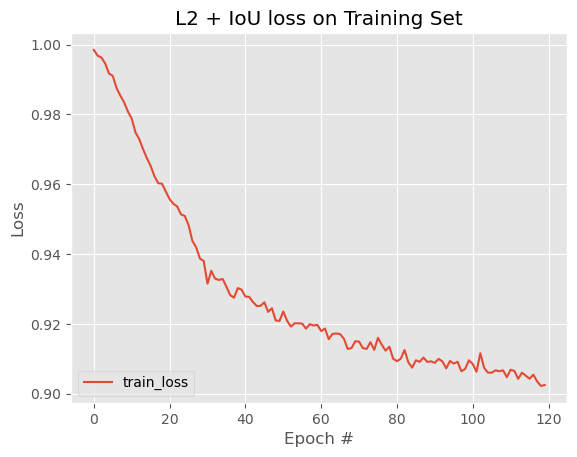

In [15]:
print("[INFO] saving object detector model...")
model.save(base_output+"/cnn_dense_2.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.title("L2 + IoU loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(base_output+"/cnn_dense_2.png")

#### CNN DENSE 2.0

In [14]:
model=cnn_dense_2()
model.compile(optimizer='adam', loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

Epoch 1/120


2023-01-03 18:23:58.202808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


  1/249 [..............................] - ETA: 17:08 - loss: 0.9973 - Accuracy: 0.2500

2023-01-03 18:23:59.414297: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


249/249 [==============================] - 10s 24ms/step - loss: 0.9979 - Accuracy: 0.2788
Epoch 2/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9964 - Accuracy: 0.3132
Epoch 3/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9955 - Accuracy: 0.3430
Epoch 4/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9937 - Accuracy: 0.4292
Epoch 5/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9905 - Accuracy: 0.5112
Epoch 6/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9880 - Accuracy: 0.5904
Epoch 7/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9848 - Accuracy: 0.6285
Epoch 8/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9819 - Accuracy: 0.6846
Epoch 9/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9785 - Accuracy: 0.7060
Epoch 10/120
249/249 [==============================] - 6s 23ms/step - loss: 0.9754 - Accurac

[INFO] saving object detector model...


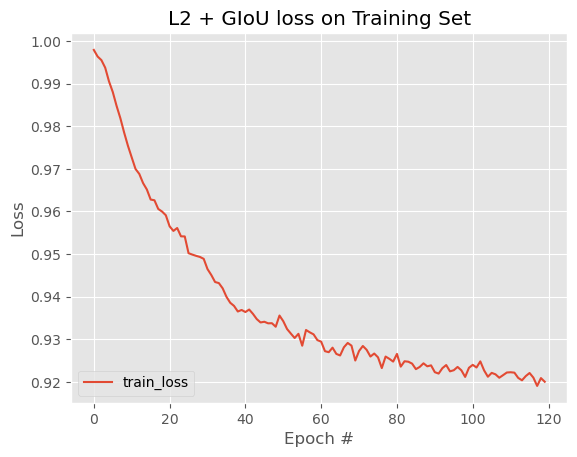

In [15]:
print("[INFO] saving object detector model...")
model.save(base_output+"/cnn_dense_2_iou.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.title("L2 + GIoU loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(base_output+"/cnn_dense_2_iou.png")

## Testing

In [18]:
model=load_model(base_output+"/cnn_dense_2.h5", compile=False)
for i,img in enumerate(trainFilenames):
    if i==20:
        break
    audioPath1=os.path.sep.join([audio_path, img[0]])
    audioPath2=os.path.sep.join([audio_path, img[1]])
    channel1,sample_rate=librosa.load(audioPath1,sr=None)
    channel2,sample_rate=librosa.load(audioPath2,sr=None)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    spectrum1=np.expand_dims(spectrum1,axis=0)
    spectrum2=np.expand_dims(spectrum2,axis=0)
    spectrogram=np.stack((spectrum1,spectrum2),axis=-1)

    # normalize
    min=spectrogram.min()
    max=spectrogram.max()
    spectrogram= (spectrogram-min)/(max-min)
    preds = model.predict(spectrogram)[0]
    (startX, startY, endX, endY) = preds
    startX,endX=startX*1440, endX*1440
    startY,endY=startY*1080, endY*1080
    width=endX-startX
    height=endY-startY
    f=open("/home/neel/Acoustic/Acoustics/dataset/labels/"+img[0][9:-4]+".txt")
    ground_truth=f.read().replace('\n','').split(" ")
    ground_startX=float(ground_truth[1])
    ground_startY=float(ground_truth[2])
    ground_width=(float(ground_truth[3])-ground_startX)
    ground_height=(float(ground_truth[4])-ground_startY)
    print("Image name: ",img[0])
    print("Ground truth: ",ground_startX,ground_startY,ground_width,ground_height)
    print("Predicted: ",startX, startY, width, height)
    

1/1 [==============================] - 0s 194ms/step
Image name:  channel1_normal_train94_20.wav
Ground truth:  1238.0 543.0 100.0 66.0
Predicted:  1203.196907043457 434.74117040634155 208.38815689086914 161.34839057922363
1/1 [==============================] - 0s 22ms/step
Image name:  channel1_normal_train52_12.wav
Ground truth:  1257.0 339.0 120.0 76.0
Predicted:  1273.9297199249268 440.0662350654602 154.1191291809082 175.7404589653015
1/1 [==============================] - 0s 19ms/step
Image name:  channel1_normal_train19_8.wav
Ground truth:  269.0 602.0 133.0 88.0
Predicted:  623.2152986526489 464.8908841609955 171.35826587677002 94.88791823387146
1/1 [==============================] - 0s 19ms/step
Image name:  channel1_3m_train43_9.wav
Ground truth:  56.0 596.0 218.0 110.0
Predicted:  219.31240797042847 514.230226278305 275.85835218429565 95.19684433937073
1/1 [==============================] - 0s 18ms/step
Image name:  channel1_4m_train51_17.wav
Ground truth:  610.0 623.0 113.0 

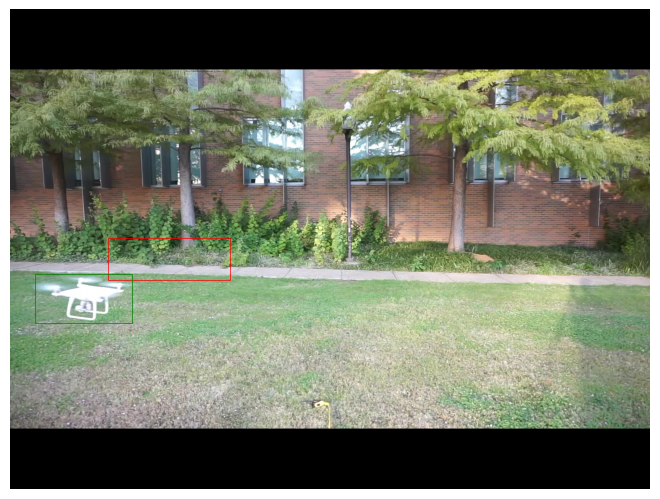

In [20]:
from matplotlib import patches
import matplotlib.pyplot as plt
import cv2

startX,startY, width, height= 219.31240797042847, 514.230226278305 ,275.85835218429565, 95.19684433937073
X,Y,W,H=56.0 ,596.0, 218.0, 110.0

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/3m_train43_9.jpg')
plt.imshow(image)
plt.axis('off')
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((X,Y),W,H, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)

In [ ]:
startX,startY, width, height= 547.1884059906006, 368.9298355579376, 184.8526096343994, 127.15006470680237
X,Y,W,H=481.99968, 332.4996 ,168.00048 ,96.999984
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/3m_train16_15.jpg')
plt.imshow(image)
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((397,284),169,97, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)